In [151]:
# Imports necessary libraries and modules
from itertools import islice
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 
import pickle
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from random import shuffle
from IPython.display import Image

In [152]:
# Directory path
os.chdir("..")
#cwd = 'input'

# Hyper Parameters
num_epochs = 3
batch_size = 2
learning_rate = 0.0001
beta = 1

# Mean and std deviation of imagenet dataset. Source: http://cs231n.stanford.edu/reports/2017/pdfs/101.pdf
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

# TODO: Define train, validation and models
MODELS_PATH = '~/Desktop/models/'
# TRAIN_PATH = cwd+'/train/'
# VALID_PATH = cwd+'/valid/'
#VALID_PATH = cwd+'/sample/valid/'
TRAIN_PATH = '~/Desktop/train'
TEST_PATH = '~/Desktop/test'

#if not os.path.exists(TRAIN_PATH): os.mkdir(TRAIN_PATH)

Set of useful functions we are going to need

In [153]:
def customized_loss(S_prime, C_prime, S, C, B):
    ''' Calculates loss specified on the paper.'''
    
    loss_cover = torch.nn.functional.mse_loss(C_prime, C)
    loss_secret = torch.nn.functional.mse_loss(S_prime, S)
    loss_all = loss_cover + B * loss_secret
    return loss_all, loss_cover, loss_secret

def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

def imshow(img, idx, learning_rate, beta):
    '''Prints out an image given in tensor format.'''
    
    img = denormalize(img, std, mean)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Example '+str(idx)+', lr='+str(learning_rate)+', B='+str(beta))
    plt.show()
    return

def gaussian(tensor, mean=0, stddev=0.1):
    '''Adds random noise to a tensor.'''
    
    noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1)
    return Variable(tensor + noise)

The author used 3x3, 4x4 and 5x5 each for the first four layers and the concatenated them and passed them to the final layer. 

This architecture was replicated exactly in each of the layers. Output of PrepNetwork (secret image preapred to merge with cover) is concatenated to the cover and fed into the hidding network. The hidding network hides the secret image in the PrepNetwork's output and returns the hidden image. This is fed into the Reveal network to output the message, that should be close to the secret image.

In [154]:
# Preparation Network (2 conv layers)
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.initialP3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialP4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialP5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalP3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalP4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalP5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())

    def forward(self, p):
        p1 = self.initialP3(p)
        p2 = self.initialP4(p)
        p3 = self.initialP5(p)
        mid = torch.cat((p1, p2, p3), 1)
        p4 = self.finalP3(mid)
        p5 = self.finalP4(mid)
        p6 = self.finalP5(mid)
        out = torch.cat((p4, p5, p6), 1)
        return out

# Hiding Network (5 conv layers)
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.initialH3 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialH4 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialH5 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalH4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalH5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))
        
    def forward(self, h):
        h1 = self.initialH3(h)
        h2 = self.initialH4(h)
        h3 = self.initialH5(h)
        mid = torch.cat((h1, h2, h3), 1)
        h4 = self.finalH3(mid)
        h5 = self.finalH4(mid)
        h6 = self.finalH5(mid)
        mid2 = torch.cat((h4, h5, h6), 1)
        out = self.finalH(mid2)
        out_noise = gaussian(out.data, 0, 0.1)
        return out, out_noise

# Reveal Network (2 conv layers)
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.initialR3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialR4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialR5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalR4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalR5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))

    def forward(self, r):
        r1 = self.initialR3(r)
        r2 = self.initialR4(r)
        r3 = self.initialR5(r)
        mid = torch.cat((r1, r2, r3), 1)
        r4 = self.finalR3(mid)
        r5 = self.finalR4(mid)
        r6 = self.finalR5(mid)
        mid2 = torch.cat((r4, r5, r6), 1)
        out = self.finalR(mid2)
        return out

# Join three networks in one module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.m1 = PrepNetwork()
        self.m2 = HidingNetwork()
        self.m3 = RevealNetwork()

    def forward(self, secret, cover):
        x_1 = self.m1(secret)
        mid = torch.cat((x_1, cover), 1)
        x_2, x_2_noise = self.m2(mid)
        x_3 = self.m3(x_2_noise)
        return x_2, x_3

In [155]:
# Creates net object
net = Net()

We create loaders for normalized training, validation and test sets

In [156]:
# Creates training set
train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TRAIN_PATH,
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=batch_size, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

# Creates test set
test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TEST_PATH, 
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=2, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

We train the model and validate it, saving the best model. We use Adam as an optimizer as the paper specifies.

In [157]:
def train_model(train_loader, beta, learning_rate):
    
    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()
        
        train_losses = []
        # Train one epoch
        for idx, train_batch in enumerate(train_loader):

            data, _  = train_batch

            # Saves secret images and secret covers
            train_covers = data[:len(data)//2]
            train_secrets = data[len(data)//2:]
            
            # Creates variable from secret and cover images
            train_secrets = Variable(train_secrets, requires_grad=False)
            train_covers = Variable(train_covers, requires_grad=False)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            train_hidden, train_output = net(train_secrets, train_covers)

            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = customized_loss(train_output, train_hidden, train_secrets, train_covers, beta)
            train_loss.backward()
            optimizer.step()
            
            # Saves training loss
            #print(train_loss.data)
            train_losses.append(train_loss.data)
            loss_history.append(train_loss.data)
            
            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(idx+1, len(train_loader), train_loss.data, train_loss_cover.data, train_loss_secret.data))
    
        #torch.save(net.state_dict(), MODELS_PATH+'Epoch N{}.pkl'.format(epoch+1))
        
        mean_train_loss = np.mean(train_losses)
    
        # Prints epoch average loss
        print ('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
                epoch+1, num_epochs, mean_train_loss))
    
    return net, mean_train_loss, loss_history

In [ ]:
net, mean_train_loss, loss_history = train_model(train_loader, beta, learning_rate)

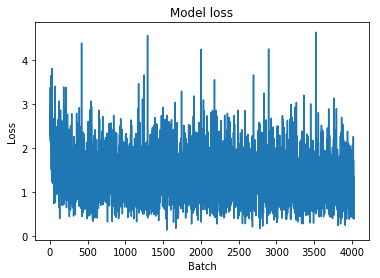

In [162]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

We test the model and print out a few images so we can visually see how good a job the model did.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.58 
Loss on secret: 0.56 
Loss on cover: 0.02


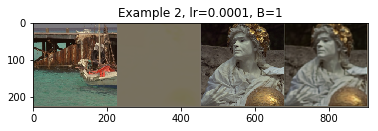

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.59 
Loss on secret: 0.57 
Loss on cover: 0.03


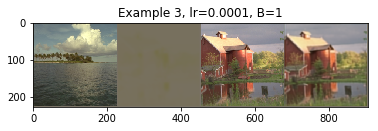

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.84 
Loss on secret: 0.82 
Loss on cover: 0.02


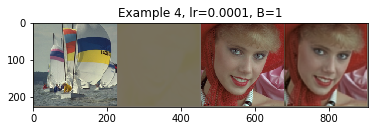

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.77 
Loss on secret: 0.74 
Loss on cover: 0.03


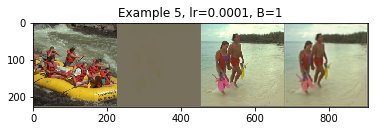

Average loss on test set: 1.00


In [161]:
# net.load_state_dict(torch.load(MODELS_PATH+'Epoch N4.pkl'))

# Switch to evaluate mode
net.eval()

test_losses = []
# Show images
for idx, test_batch in enumerate(test_loader):
     # Saves images
    data, _ = test_batch

    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    test_secret = Variable(test_secret, volatile=True)
    test_cover = Variable(test_cover, volatile=True)

    # Compute output
    test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
#     diff_S, diff_C = np.abs(np.array(test_output.data[0]) - np.array(test_secret.data[0])), np.abs(np.array(test_hidden.data[0]) - np.array(test_cover.data[0]))
    
#     print (diff_S, diff_C)
    
    if idx in [1,2,3,4]:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(test_loss.data, loss_secret.data, loss_cover.data))

        # Creates img tensor
        imgs = [test_secret.data, test_output.data, test_cover.data, test_hidden.data]
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)
        
    test_losses.append(test_loss.data)
        
mean_test_loss = np.mean(test_losses)

print ('Average loss on test set: {:.2f}'.format(mean_test_loss))